In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error
import plotly.express as px
import optuna
import os
import json
import warnings
import scipy.stats as stats
from scipy.stats import wilcoxon
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from tqdm import tqdm
from itertools import product
from scipy.stats import t

warnings.filterwarnings(
    "ignore",
    message=".*The least populated class in y has only.*",
    category=UserWarning
)

random.seed(42)
np.random.seed(42)

# Data preparation

In [2]:
df = pd.read_csv('./data/JD_house_prices.csv')

In [3]:
df.head(10)

price  live_rooms  live_square   map_city    map_lat    map_lon  year  \
0  21500000           2           47  караганда  49.777852  73.138243  1972   
1  58600000           4          108  караганда  49.779672  73.132440  2020   
2  38500000           2           71  караганда  49.797291  73.142052  2021   
3   9000000           2           44  караганда  49.807940  73.054736  1955   
4  22880000           3           88  караганда  49.778597  73.059382  2025   
5  10500000           2           44  караганда  49.895854  73.208797  1969   
6  27000000           4           74  караганда  49.768409  73.133689  1980   
7  15500000           1           45  караганда  49.801690  73.135530  2023   
8  28000000           3           82  караганда  49.822275  73.104727  1955   
9  33000000           3           82  караганда  49.795102  73.151323  2009   

   house_complex_name  flat_floor  house_floor_num  flat_building  \
0               349.0         4.0              5.0            2.0   
1              1171.0         1.0             10.0            1.0   
2              1976.0         2.0             10.0            1.0   
3               177.0         1.0              5.0            1.0   
4              2408.0         3.0              5.0            1.0   
5              1249.0         4.0              5.0            2.0   
6              1605.0         8.0              9.0            1.0   
7              1777.0         4.0              4.0            1.0   
8              2530.0         2.0              2.0            1.0   
9              3417.0         9.0             10.0            3.0   

   flat_renovation  live_furniture  flat_toilet  mortgage  flat_priv_dorm  
0              1.0             2.0          2.0       0.0             2.0  
1              1.0             1.0          3.0       0.0             2.0  
2              1.0             2.0          2.0       0.0             2.0  
3              1.0             2.0          1.0       0.0             2.0  
4              5.0             3.0          1.0       0.0             2.0  
5              1.0             2.0          2.0       0.0             2.0  
6              1.0             1.0          1.0       0.0             2.0  
7              5.0             2.0          2.0       0.0             2.0  
8              1.0             2.0          2.0       0.0             2.0  
9              1.0             1.0          2.0       0.0             2.0

In [4]:
print(df.isna().sum())

price                 0
live_rooms            0
live_square           0
map_city              0
map_lat               0
map_lon               0
year                  0
house_complex_name    0
flat_floor            0
house_floor_num       0
flat_building         0
flat_renovation       0
live_furniture        0
flat_toilet           0
mortgage              0
flat_priv_dorm        0
dtype: int64


In [5]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 1478


In [6]:
df = df.drop_duplicates()
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


In [7]:
def encode_map_city(X_train, y_train, X_test, X_val = None):
    target_encoder = ce.TargetEncoder(cols=['map_city'])

    X_train['map_city'] = target_encoder.fit_transform(X_train['map_city'], y_train)
    X_test['map_city'] = target_encoder.transform(X_test['map_city'])

    if X_val is not None:
        X_val['map_city'] = target_encoder.transform(X_val['map_city'])

# Distribution shift

In the previous section, we observed that the optimal parameters—those with the lowest mean test RMSE from 10-fold cross-validation—are larger than the hand-picked ones and considered prone to overfitting. It's possible that our train/test split is masking this issue. To investigate further, let's simulate a distribution shift and see whether more conservative parameters perform better in such a case. 

## Optuna without regularization

The thing about tuning hyperparameters is that it takes a lot of time. The more hyperparameters you tune at once, the more trials you need to run. So, I usually approach hyperparameter tuning in two stages. First, I tune the structural parameters (n_estimators, learning_rate, num_leaves, max_depth). Then, in the second stage, I tune the regularization parameters while keeping the structural ones mostly fixed.

It's practical, makes sense logically, and I’ve read somewhere that others follow the same approach.

So, let’s do it.

We will use 10-fold cross-validation with RMSE as the metric to do it.

In [59]:
X = df.drop(columns=['price'])
y = df['price']

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📌 Размер обучающей выборки: {X_train_cv.shape}")
print(f"📌 Размер тестовой выборки: {X_test_cv.shape}")

📌 Размер обучающей выборки: (38781, 15)
📌 Размер тестовой выборки: (9696, 15)


In [60]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [1000, 4500, 6000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'num_leaves': trial.suggest_categorical('num_leaves', [31, 100, 150, 200, 300]),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 2, 3, 5, 10, 20, 30, 50]),
        'objective': 'regression',
        'metric': 'rmse',
        "verbose": -1,
        'random_state': 42,
    }


    FOLDS = 10
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    oof_preds = np.zeros(X_train_cv.shape[0])

    for i, (train_index, test_index) in enumerate(kf.split(X_train_cv, y_train_cv)):
        X_train_cv_fold = X_train_cv.iloc[train_index].copy()
        y_train_cv_fold = y_train_cv.iloc[train_index].copy()
        X_valid_fold = X_train_cv.iloc[test_index].copy()
        y_valid_fold = y_train_cv.iloc[test_index].copy()

        model = LGBMRegressor(**params)
        model.fit(
            X_train_cv_fold, y_train_cv_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            callbacks=[
                lgb.early_stopping(100, verbose=False),
            ],
        )

        oof_preds[test_index] = model.predict(X_valid_fold)

    oof_m = root_mean_squared_error(y_train_cv, oof_preds)

    return oof_m


study = optuna.create_study(direction='minimize', study_name='target_encoder_hand')
# study.optimize(objective, n_trials=200, callbacks=[save_best_trial_periodically])

# print(f"Best parameters: {json.dumps(study.best_params, indent=4)}")

[I 2025-05-13 08:53:42,179] A new study created in memory with name: target_encoder_hand


### Found params

In [61]:
optuna_params = {
    "n_estimators": 6000,
    "learning_rate": 0.02345649646891381,
    'num_leaves': 100,
    'max_depth': 15,
    'min_child_samples': 2,
    "verbose": -1,
    'random_state': 42,
}

### 🔍 ChatGPT parameter analysis:

| **Parameter**        | **Value**               | **Comment**                                                                 |
|----------------------|-------------------------|------------------------------------------------------------------------------|
| `n_estimators`       | 6000                    | ⚠️ Very high — without early stopping, this may overfit.                    |
| `learning_rate`      | 0.02345649646891381     | ✅ Reasonably low — helps avoid overfitting, but needs many trees.          |
| `num_leaves`         | 100                     | ⚠️ Quite high — more leaves = more complexity. Could overfit.               |
| `max_depth`          | 15                      | ⚠️ Deep trees = more flexibility = higher risk of overfitting.              |
| `min_child_samples`  | 2                       | ❗ Very risky — allows splits with very few data points (overfitting risk).  |


Ok, let's test for overfitting.

### Testing using CV

To test for overfitting, we:

For each model:
- Run 10-fold cross-validation 5 times and collect RMSE scores
- Compute the mean, standard deviation, and 95% confidence intervals for RMSE
- Measure the percentage gap between training and validation RMSE

We’ll visualize RMSE distributions using box plots.

The main statistical test is the Wilcoxon signed-rank test, which checks whether the RMSE differences between models are statistically significant.

In [62]:
# DFs to store experiment results
results_cv_df = pd.DataFrame(columns=['Mean RMSE', 'Std Dev RMSE', 'CI lower', 'CI upper', 'Gap %'])
results_cv_df.index.name = 'Model'

tests_cv_df = pd.DataFrame(columns=['Statistic', 'p-value', 'Significance', 'Better Model'])
tests_cv_df.index.name = 'Test'

### Nadeau and Bengio’s corrected t-test

from https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

with slight modifications, mostly changed test to two-tailed

In [63]:
def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(model1_scores, model2_scores, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    model1_scores : array-like of shape (n_samples,)
        Vector containing the scores of the first model.
    model2_scores : array-like of shape (n_samples,)
        Vector containing the scores of the second model.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """

    differences = model1_scores - model2_scores
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    df = len(differences) - 1
    p_val = 2 * t.sf(np.abs(t_stat), df)  # two-tailed t-test

    return t_stat, p_val

In [64]:
def plot_ci(rmses1, rmses2, name1, name2):
    df_plot = pd.DataFrame({
        'RMSE': np.concatenate([rmses1, rmses2]),
        'Model': [name1] * len(rmses1) + [name2] * len(rmses2)
    })

    fig = px.box(df_plot, x="Model", y="RMSE", title="RMSE Distribution per Model")
    fig.update_layout(height=500, width=700)
    fig.show()

def test_cv_repeated(params, name):
    rmses = []
    gaps = []

    for run in range(5):
        FOLDS = 10
        kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42 + run)

        for i, (train_index, test_index) in enumerate(kf.split(X_train_cv, y_train_cv)):
            X_train_cv_fold = X_train_cv.iloc[train_index].copy()
            y_train_cv_fold = y_train_cv.iloc[train_index].copy()
            X_valid_fold = X_train_cv.iloc[test_index].copy()
            y_valid_fold = y_train_cv.iloc[test_index].copy()

            encode_map_city(X_train_cv_fold, y_train_cv_fold, X_valid_fold)

            model = LGBMRegressor(**params)

            model.fit(
                X_train_cv_fold, y_train_cv_fold,
                eval_set=[(X_valid_fold, y_valid_fold)],
                callbacks=[
                    lgb.early_stopping(250, verbose=False),
                ],
            )

            train_rmse = root_mean_squared_error(y_train_cv_fold, model.predict(X_train_cv_fold))
            valid_rmse = root_mean_squared_error(y_valid_fold, model.predict(X_valid_fold))

            rmses.append(valid_rmse)

            gap = (valid_rmse - train_rmse)/train_rmse * 100
            gaps.append(gap)

    all_rmse = np.array(rmses)
    mean = np.mean(all_rmse)
    std = np.std(all_rmse, ddof=1)
    confidence = 0.95
    ci = stats.t.interval(confidence, df=len(all_rmse)-1,
                        loc=mean,
                        scale=std)

    return all_rmse, mean, std, ci, gaps, len(y_train_cv_fold), len(y_valid_fold)

def compare_cv_params(params1, name1, params2, name2):
    global results_cv_df, tests_cv_df


    rmses1, mean1, std1, ci1, gaps1, n_train_fold, n_test_fold = test_cv_repeated(params1, name1)
    rmses2, mean2, std2, ci2, gaps2, _, _ = test_cv_repeated(params2, name2)

    df_results = pd.DataFrame({
        'Model': [name1, name2],
        'Mean RMSE': [int(mean1), int(mean2)],
        'Std Dev RMSE': [int(std1), int(std2)],
        'CI lower': [int(ci1[0]), int(ci2[0])],
        'CI upper': [int(ci1[1]), int(ci2[1])],
        'Gap %': [int(np.mean(gaps1)), int(np.mean(gaps2))]
    })
    df_results.set_index('Model', inplace=True)
    print(df_results.head().to_string())

    rmse_diff = np.abs(mean1 - mean2)
    rmse_diff_percent = np.abs(mean1 - mean2) / ((mean1 + mean2) / 2) * 100
    print(f"RMSE Difference: {rmse_diff:.0f}, RMSE Difference %: {rmse_diff_percent:.2f}")

    results_cv_df.update(df_results)
    results_cv_df = results_cv_df.combine_first(df_results)


    plot_ci(rmses1, rmses2, name1, name2)


    # stat, p = wilcoxon(rmses1, rmses2, alternative='two-sided')
    # print(f"\n[Wilcoxon Test] Statistic: {stat:.4f}, p-value: {p:.4f}")

    _, shapiro_p = stats.shapiro(rmses1)
    print(f"Shapiro-Wilk p-value: {shapiro_p:.4f} -> {'Normal RMSE distribution' if shapiro_p > 0.05 else 'Not normal RMSE distribution'}")

    stat, p = compute_corrected_ttest(rmses1, rmses2, n_train_fold, n_test_fold)
    print(f"\n[Corrected t-test] Statistic: {stat:.4f}, p-value: {p:.4f}")

    if p < 0.05:
        significant = True
        better = name1 if mean1 < mean2 else name2
        print(f"\n✅ Statistically significant difference (p < 0.05)")
        print(f"🏆 {better} is better")
    else:
        significant = False
        print(f"\n❌ No statistically significant difference (p >= 0.05)")
        print(f"🏆 Both models are similar (mean RMSE: {mean1:.4f} vs {mean2:.4f})")

    tests_cv_df.loc[name1 + ' vs ' + name2] = [
        stat,
        p,
        "Statistically significant" if significant else "Not significant",
        better if significant else "Both models are similar"
    ]


### CV: Hand-Picked vs. Optuna

In [65]:
hand_picked_params = {
    "n_estimators": 6000,
    "learning_rate": 0.05,
    "max_depth": 10,
    "num_leaves": 31,
    "min_child_samples": 20,
    "verbose": -1,
    'random_state': 42,
}
optuna_params = {
    "n_estimators": 6000,
    "learning_rate": 0.02345649646891381,
    'num_leaves': 100,
    'max_depth': 15,
    'min_child_samples': 2,
    "verbose": -1,
    'random_state': 42,
}
compare_cv_params(hand_picked_params, "Hand-picked", optuna_params, "Optuna")

             Mean RMSE  Std Dev RMSE  CI lower  CI upper  Gap %
Model                                                          
Hand-picked    4555430         98808   4356866   4753993    106
Optuna         4485091         97829   4288495   4681688    355
RMSE Difference: 70338, RMSE Difference %: 1.56


Shapiro-Wilk p-value: 0.0981 -> Normal RMSE distribution

[Corrected t-test] Statistic: 4.5754, p-value: 0.0000

✅ Statistically significant difference (p < 0.05)
🏆 Optuna is better


As expected, the model trained with parameters found by Optuna is performing better—by quite a margin, actually: a 1.56% improvement.

So what? No overfitting? Well, it depends. Our cross-validation uses KFold, which splits the data randomly into k folds (shuffle=True). The thing about random splits is that, when you have enough data, the folds tend to have very similar—if not nearly identical—distributions. This means we're not really testing our model on truly unseen data. Unless something is seriously broken, you’re unlikely to detect overfitting in this setup.

What we could try is simulating a distribution shift. That way, we can see how the model behaves when the conditions change.

## Prepare shifted data

The dataset will be split into two parts: training and testing, with an 80/20% split. Several modifications will be made to the test data to simulate distribution shift.

To evaluate how well the model handles unseen data:
- 50% of the house complexes in the test set will be unique to the test set.
- 50% of the data points in the test set will be the southernmost by city (thus only appearing in the test set).
- Year values will be shifted: years ≥ 2020 will be increased by 6 years, and years ≤ 1980 will be decreased by 40 years.
- 10% of the renovation and furniture states in the test set will be changed to entirely new, unseen values.

There will be changes to price based on some variables:
- A non-linear transformation will be applied to the price based on floor level: increasing prices for lower floors and decreasing prices for higher floors.
- Prices will be adjusted slightly based on renovation state.
- Prices of apartments with live_furniture == 3 will be increased.

Added noise:
- Random noise (~500m) will be added to the coordinates.
- 10% of the renovation and furniture states in the test data will be changed to random values.

These changes probably wouldn't happen in practice, but I want to detect overfitting, which is why the modifications are a bit extreme.

### Holdout House Complex

In [66]:
# Step 1: Get top 10 most frequent complexes
top_10_complexes = (
    df['house_complex_name']
    .value_counts()
    .head(10)
    .index
    .tolist()
)

# Step 2: Get candidate complexes (not in top 10)
candidate_complexes = df.loc[~df['house_complex_name'].isin(top_10_complexes), 'house_complex_name'].dropna().unique()

# Step 3: Shuffle and select enough to hit 10% of total rows
rng = np.random.default_rng(42)
rng.shuffle(candidate_complexes)

test_complexes = []
row_count = 0
target_count = int(0.1 * len(df))

for complex_name in candidate_complexes:
    complex_rows = df[df['house_complex_name'] == complex_name]
    row_count += len(complex_rows)
    test_complexes.append(complex_name)
    if row_count >= target_count:
        break

# Step 4: Create final splits
test_df = df[df['house_complex_name'].isin(test_complexes)].reset_index(drop=True)
# test_df['test_complex'] = True
train_df = df[~df['house_complex_name'].isin(test_complexes)].reset_index(drop=True)
# train_df['test_complex'] = False

# Step 5: Final checks
assert not set(train_df['house_complex_name']).intersection(set(test_df['house_complex_name']))
assert all(c in train_df['house_complex_name'].values for c in top_10_complexes)

common_rows = test_df.merge(train_df.drop_duplicates(), how='inner')
print("Common rows between test and train:", len(common_rows))

print(f"📌 Размер обучающей выборки: {train_df.shape}")
print(f"📌 Размер тестовой выборки: {test_df.shape}")


Common rows between test and train: 0
📌 Размер обучающей выборки: (43597, 16)
📌 Размер тестовой выборки: (4880, 16)


### South points

In [67]:
# 1. How many total test rows we want
target_total_rows = int(0.2 * len(df))
remaining_needed   = target_total_rows - len(test_df)

# 2. Work only with the part of train_df that isn’t already in test_df
remaining_train = train_df.loc[~train_df.index.isin(test_df.index)]

# 3. Group by city and sort each group so the southmost (lowest lat) comes first
city_groups = {
    city: grp.sort_values("map_lat", ascending=True)
    for city, grp in remaining_train.groupby("map_city")
}

south_holdout_list = []

# 4. Round‑robin pick one southmost row per city until we have enough
while remaining_needed > 0 and city_groups:
    for city in list(city_groups):
        grp = city_groups[city]
        if grp.empty:
            del city_groups[city]
            continue

        idx = grp.index[0]               # the original df‑index of the southmost row
        south_holdout_list.append(idx)

        # drop that row from further consideration
        city_groups[city] = grp.iloc[1:]
        remaining_needed -= 1

        if remaining_needed <= 0:
            break

# 5. Filter out any indices that somehow snuck in from the original test_df
south_holdout_list = [i for i in south_holdout_list if i not in test_df.index]

# 6. Pull those rows out of train_df, append to test_df, and then drop them
south_holdout_df = train_df.loc[south_holdout_list]
# south_holdout_df['test_south'] = True

# test_df['test_south'] = False
# train_df['test_south'] = False

test_df  = pd.concat([test_df,  south_holdout_df]).reset_index(drop=True)
train_df = train_df.drop(south_holdout_list).reset_index(drop=True)

common_rows = test_df.merge(train_df.drop_duplicates(), how='inner')
print("Common rows between test and train:", len(common_rows))

# Within train
duplicates_in_train = train_df.duplicated()
print("Train duplicates:", duplicates_in_train.sum())

# Within test
duplicates_in_test = test_df.duplicated()
print("Test duplicates:", duplicates_in_test.sum())


print(f"📌 Размер обучающей выборки: {train_df.shape}")
print(f"📌 Размер тестовой выборки: {test_df.shape}")

Common rows between test and train: 0
Train duplicates: 0
Test duplicates: 0
📌 Размер обучающей выборки: (38782, 16)
📌 Размер тестовой выборки: (9695, 16)


In [68]:
# Filter only rows where test_south is True
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    lat=south_holdout_df['map_lat'],
    lon=south_holdout_df['map_lon'],
    mode='markers',
    marker=dict(size=8, color='green'),
    name='test_south',
    text=south_holdout_df['house_complex_name'],
    hoverinfo='text'
))

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=11,
    mapbox_center={"lat": 43.18, "lon": 76.8897},
    height=800,
    title="Only test_south == True"
)

fig.show()

In [69]:
train_df_map = train_df.copy()
test_df_map = test_df.copy()

# Step 1: Get sets
train_complexes = set(train_df_map['house_complex_name'].unique())
test_complexes = set(test_df_map['house_complex_name'].unique())

# Step 2: Label each dataset
def classify_complex(row):
    name = row['house_complex_name']
    if name in train_complexes and name in test_complexes:
        return 'both'
    elif name in train_complexes:
        return 'train_only'
    else:
        return 'test_only'

train_df_map['complex_origin'] = train_df_map.apply(classify_complex, axis=1)
test_df_map['complex_origin'] = test_df_map.apply(classify_complex, axis=1)

# Step 3: Plot each group with a different color
fig = go.Figure()

color_map = {
    'train_only': 'blue',
    'test_only': 'red',
    'both': 'gold'
}

for label in ['train_only', 'test_only', 'both']:
    subset = pd.concat([
        train_df_map[train_df_map['complex_origin'] == label],
        test_df_map[test_df_map['complex_origin'] == label]
    ], ignore_index=True, sort=False).dropna(subset=['map_lat', 'map_lon'])

    fig.add_trace(go.Scattermapbox(
        lat=subset['map_lat'],
        lon=subset['map_lon'],
        mode='markers',
        marker=dict(size=8, color=color_map[label]),
        name=label,
        text=subset['house_complex_name'],
        hoverinfo='text'
    ))

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=11,
    mapbox_center={"lat": 43.23, "lon": 76.8897},
    height=800,
    title="House Complex Origin: Train Only / Test Only / Both"
)

fig.show()

In [70]:
test_df_backup = test_df.copy()

### Lat/Long jitter

In [71]:
# Randomly sample 50% of the test set indices (with fixed seed for reproducibility)
coord_noise_idx = test_df.sample(frac=0.2, random_state=42).index

# 350-550m
test_df.loc[coord_noise_idx, 'map_lat'] += np.random.normal(0, 0.005, size=len(coord_noise_idx))
test_df.loc[coord_noise_idx, 'map_lon'] += np.random.normal(0, 0.005, size=len(coord_noise_idx))

In [72]:
test_df_map = test_df.copy()

fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    lat=test_df_map['map_lat'],
    lon=test_df_map['map_lon'],
    mode='markers',
    marker=dict(size=8, color='red'),
    name='Test Data',
    text=test_df_map['house_complex_name'],
    hoverinfo='text'
))

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=15,
    mapbox_center={"lat": 43.225, "lon": 76.8897},
    height=800,
    title="Test Data House Complex Locations"
)

fig.show()


### Floor price

In [73]:
mid = 5
floor_penalty = np.where(
    test_df['flat_floor'] < mid,
    0.01 * (test_df['flat_floor'] - mid) ** 2 + 1.0,  # < 10 → less than 1.0
    -0.001 * (test_df['flat_floor'] - mid) ** 2 + 1.0    # ≥ 10 → more than 1.0
)
floor_penalty_df = test_df[['flat_floor']].copy()
floor_penalty_df['floor_penalty'] = floor_penalty
print(floor_penalty_df.groupby('flat_floor').mean().to_string())

            floor_penalty
flat_floor               
1.0                 1.160
2.0                 1.090
3.0                 1.040
4.0                 1.010
5.0                 1.000
6.0                 0.999
7.0                 0.996
8.0                 0.991
9.0                 0.984
10.0                0.975
11.0                0.964
12.0                0.951
13.0                0.936
14.0                0.919
15.0                0.900
16.0                0.879
17.0                0.856
18.0                0.831
19.0                0.804
20.0                0.775
21.0                0.744
22.0                0.711
23.0                0.676
24.0                0.639
25.0                0.600
26.0                0.559
29.0                0.424


In [74]:
test_df['price'] = test_df['price'] * floor_penalty

In [75]:
# Group and compute mean price by floor
mean_price_backup = test_df_backup.groupby("flat_floor")["price"].mean()
mean_price_current = test_df.groupby("flat_floor")["price"].mean()

# Align on common floors
common_floors = sorted(set(mean_price_backup.index).intersection(mean_price_current.index))

# Bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=common_floors,
    y=[mean_price_backup.loc[f] for f in common_floors],
    name='Backup',
    marker_color='mediumturquoise'
))

fig.add_trace(go.Bar(
    x=common_floors,
    y=[mean_price_current.loc[f] for f in common_floors],
    name='Current',
    marker_color='indianred'
))

fig.update_layout(
    title='Mean Price per Flat Floor (original vs shifted)',
    xaxis_title='Flat Floor',
    yaxis_title='Mean Price',
    barmode='group',
    height=500,
    width=900
)

fig.show()


### Shift year

In [76]:
test_df.loc[test_df['year'] >= 2020, 'year'] += 6
test_df.loc[test_df['year'] <= 1980, 'year'] -= 40


In [77]:
# Define consistent bins
all_years = pd.concat([test_df['year'], test_df_backup['year']])
bin_start = all_years.min()
bin_end = all_years.max()
bin_size = (bin_end - bin_start) / 50

fig = go.Figure()

# Histogram for original
fig.add_trace(go.Histogram(
    x=test_df_backup['year'],
    name='original',
    opacity=0.6,
    marker_color='darkorange',
    xbins=dict(
        start=bin_start,
        end=bin_end,
        size=bin_size
    )
))

# Histogram for shifted
fig.add_trace(go.Histogram(
    x=test_df['year'],
    name='shifted',
    opacity=0.6,
    marker_color='mediumpurple',
    xbins=dict(
        start=bin_start,
        end=bin_end,
        size=bin_size
    )
))

fig.update_layout(
    title="Distribution of Construction Years: test_df vs test_df_backup",
    xaxis_title="Year",
    yaxis_title="Count",
    bargap=0.1,
    barmode='overlay',
    height=500,
    width=800
)

fig.show()

### Bump Renovation

In [78]:
# 5. Bump price for flat_renovation
test_df_before = test_df.copy()

renovation_price_multiplier = {
    2: 1.10,
    4: 1.15,
    5: 1.20
}
test_df['price'] *= test_df['flat_renovation'].map(renovation_price_multiplier).fillna(1.0)

In [79]:
# Compute group means
renov_backup = test_df_before.groupby("flat_renovation")["price"].mean()
renov_current = test_df.groupby("flat_renovation")["price"].mean()

# Sort keys
renov_keys = sorted(set(renov_backup.index).intersection(renov_current.index))

# Plot for flat_renovation
fig1 = go.Figure()

fig1.add_trace(go.Bar(
    x=renov_keys,
    y=[renov_backup.loc[k] for k in renov_keys],
    name='Backup',
    marker_color='darkcyan'
))
fig1.add_trace(go.Bar(
    x=renov_keys,
    y=[renov_current.loc[k] for k in renov_keys],
    name='Current',
    marker_color='coral'
))

fig1.update_layout(
    title='Mean Price by Flat Renovation',
    xaxis_title='Flat Renovation',
    yaxis_title='Mean Price',
    barmode='group',
    height=450,
    width=800
)

fig1.show()

### Renovation jitter

In [80]:
# total 20% to split into two 10%
flip_idx_total = test_df.sample(frac=0.2, random_state=42).index

# Step 2: Split into two disjoint sets
flip_idx_1 = flip_idx_total[:len(flip_idx_total)//2]
flip_idx_2 = flip_idx_total[len(flip_idx_total)//2:]

# Step 3: Assign values separately
test_df.loc[flip_idx_1, 'flat_renovation'] = np.random.choice([1, 2, 4, 5], size=len(flip_idx_1))
test_df.loc[flip_idx_2, 'flat_renovation'] = np.random.choice([3, 6, 7, 8], size=len(flip_idx_2))

array([[<Axes: title={'center': 'flat_renovation'}>]], dtype=object)

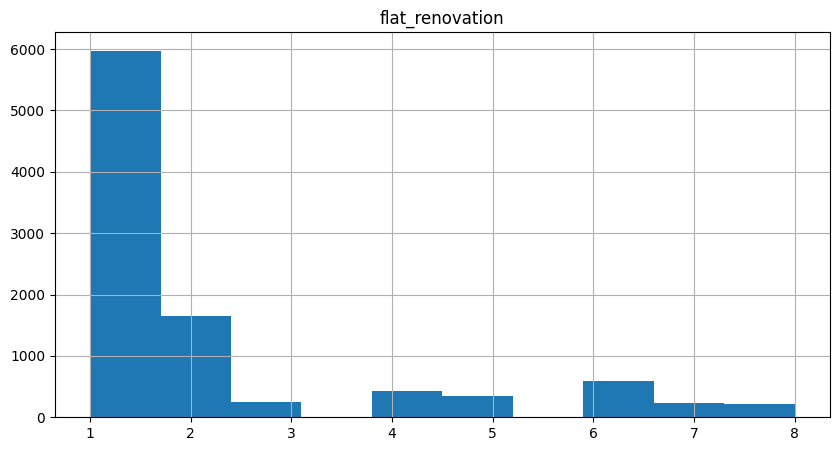

In [81]:
test_df.hist(column='flat_renovation', figsize=(10, 5))

### Bump furniture

In [82]:
# 6. Bump price if live_furniture == 3
test_df_before = test_df.copy()
test_df.loc[test_df['live_furniture'] == 3, 'price'] *= 1.15

In [83]:
# Compute group means
furn_backup = test_df_before.groupby("live_furniture")["price"].mean()
furn_current = test_df.groupby("live_furniture")["price"].mean()

# Sort keys
furn_keys = sorted(set(furn_backup.index).intersection(furn_current.index))

# Plot for live_furniture
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=furn_keys,
    y=[furn_backup.loc[k] for k in furn_keys],
    name='Backup',
    marker_color='darkgreen'
))
fig2.add_trace(go.Bar(
    x=furn_keys,
    y=[furn_current.loc[k] for k in furn_keys],
    name='Current',
    marker_color='orangered'
))

fig2.update_layout(
    title='Mean Price by Furniture Presence',
    xaxis_title='Live Furniture',
    yaxis_title='Mean Price',
    barmode='group',
    height=450,
    width=800
)

fig2.show()


### Furniture jitter

In [84]:
# total 20% to split into two 10%
flip_idx_total = test_df.sample(frac=0.2, random_state=42).index

# Step 2: Split into two disjoint sets
flip_idx_1 = flip_idx_total[:len(flip_idx_total)//2]
flip_idx_2 = flip_idx_total[len(flip_idx_total)//2:]

# Step 3: Assign values separately
test_df.loc[flip_idx_1, 'live_furniture'] = np.random.choice([1, 2, 3], size=len(flip_idx_1))
test_df.loc[flip_idx_2, 'live_furniture'] = np.random.choice([4, 5, 6], size=len(flip_idx_2))

array([[<Axes: title={'center': 'live_furniture'}>]], dtype=object)

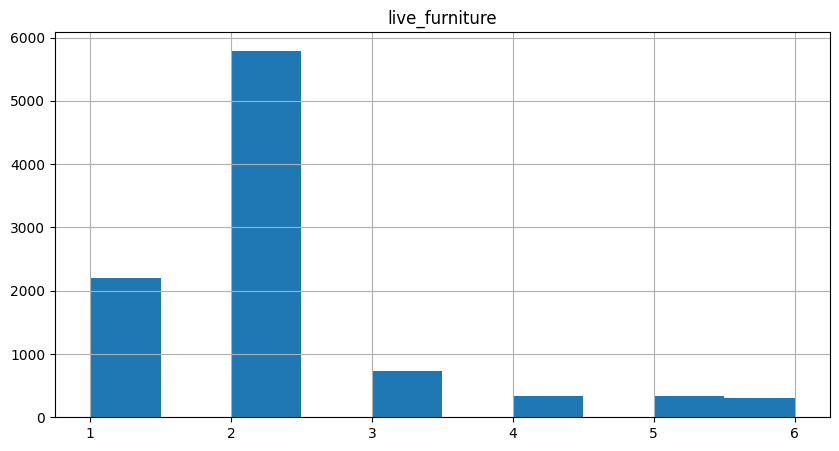

In [85]:
test_df.hist(column='live_furniture', figsize=(10, 5))

### Final price distribution

In [86]:
# Combine prices to get global min/max
all_prices = pd.concat([test_df_backup['price'], test_df['price']])
bin_start = all_prices.min()
bin_end = all_prices.max()
bin_size = (bin_end - bin_start) / 100

fig = go.Figure()

# Original prices
fig.add_trace(go.Histogram(
    x=test_df_backup["price"],
    name="Original",
    opacity=0.6,
    marker_color='teal',
    xbins=dict(
        start=bin_start,
        end=bin_end,
        size=bin_size
    )
))

# Shifted prices
fig.add_trace(go.Histogram(
    x=test_df["price"],
    name="Shifted",
    opacity=0.6,
    marker_color='crimson',
    xbins=dict(
        start=bin_start,
        end=bin_end,
        size=bin_size
    )
))

fig.update_layout(
    title="Price Distribution: original vs shifted",
    xaxis_title="Price",
    yaxis_title="Count",
    barmode='overlay',
    height=500,
    width=900
)

fig.show()

## Testing using shifted data

Testing with shifted data is similar: we train on unshifted data using 10-fold cross-validation, but instead of comparing out-of-fold (OOF) predictions, we compare predictions on the shifted test data in each CV run. There are still five CV runs, as before.

In [87]:
X_train = train_df.drop(columns=['price'])
y_train = train_df['price']

X_test_shifted = test_df.drop(columns=['price'])
y_test_shifted = test_df['price']

print(f"📌 Размер обучающей выборки: {X_train.shape}")
print(f"📌 Размер shifted выборки: {X_test_shifted.shape}")

📌 Размер обучающей выборки: (38782, 15)
📌 Размер shifted выборки: (9695, 15)


In [88]:
X_train.head()

live_rooms  live_square   map_city    map_lat    map_lon  year  \
0           2           47  караганда  49.777852  73.138243  1972   
1           4          108  караганда  49.779672  73.132440  2020   
2           2           71  караганда  49.797291  73.142052  2021   
3           2           44  караганда  49.807940  73.054736  1955   
4           3           88  караганда  49.778597  73.059382  2025   

   house_complex_name  flat_floor  house_floor_num  flat_building  \
0               349.0         4.0              5.0            2.0   
1              1171.0         1.0             10.0            1.0   
2              1976.0         2.0             10.0            1.0   
3               177.0         1.0              5.0            1.0   
4              2408.0         3.0              5.0            1.0   

   flat_renovation  live_furniture  flat_toilet  mortgage  flat_priv_dorm  
0              1.0             2.0          2.0       0.0             2.0  
1              1.0             1.0          3.0       0.0             2.0  
2              1.0             2.0          2.0       0.0             2.0  
3              1.0             2.0          1.0       0.0             2.0  
4              5.0             3.0          1.0       0.0             2.0

In [89]:
X_test_shifted.head()

live_rooms  live_square   map_city    map_lat    map_lon  year  \
0           2           44  караганда  49.773473  73.128569  1939   
1           2           40  караганда  49.803987  73.095070  1933   
2           2           52  караганда  49.777289  73.136190  1935   
3           3           98  караганда  49.802949  73.139338  2030   
4           4          140  караганда  49.792292  73.159907  2027   

   house_complex_name  flat_floor  house_floor_num  flat_building  \
0              3321.0         1.0              5.0            2.0   
1              3300.0         2.0              9.0            1.0   
2              2116.0         7.0              9.0            2.0   
3              3330.0        10.0             10.0            1.0   
4              1735.0         5.0              5.0            1.0   

   flat_renovation  live_furniture  flat_toilet  mortgage  flat_priv_dorm  
0              4.0             2.0          2.0       0.0             2.0  
1              1.0             2.0          2.0       0.0             2.0  
2              1.0             3.0          2.0       0.0             2.0  
3              1.0             1.0          2.0       0.0             2.0  
4              1.0             2.0          3.0       0.0             2.0

In [90]:
results_shifted_df = pd.DataFrame(columns=['Mean RMSE', 'Std Dev RMSE', 'CI lower', 'CI upper'])
results_shifted_df.index.name = 'Model'

tests_shifted_df = pd.DataFrame(columns=['Statistic', 'p-value', 'Significance', 'Better Model', 'Difference %'])
tests_shifted_df.index.name = 'Test'

In [92]:
def compare_params_shifted(params1, name1, params2, name2):
    global results_shifted_df, tests_shifted_df

    def test_repeated(params, name):
        rmses = []

        for run in range(5):
            FOLDS = 10
            kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42 + run)

            for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
                X_train_fold = X_train.iloc[train_index].copy()
                y_train_fold = y_train.iloc[train_index].copy()
                X_valid_fold = X_train.iloc[test_index].copy()
                y_valid_fold = y_train.iloc[test_index].copy()
                X_test_shifted_fold = X_test_shifted.copy()

                encode_map_city(X_train_fold, y_train_fold, X_valid_fold, X_test_shifted_fold)

                model = LGBMRegressor(**params)

                model.fit(
                    X_train_fold, y_train_fold,
                    eval_set=[(X_valid_fold, y_valid_fold)],
                    callbacks=[
                        lgb.early_stopping(250, verbose=False),
                    ],
                )

                rmse = root_mean_squared_error(y_test_shifted, model.predict(X_test_shifted_fold))

                rmses.append(rmse)

        all_rmse = np.array(rmses)
        mean = np.mean(all_rmse)
        std = np.std(all_rmse, ddof=1)
        confidence = 0.95
        ci = stats.t.interval(confidence, df=len(all_rmse)-1,
                            loc=mean,
                            scale=std)

        return all_rmse, mean, std, ci


    rmses1, mean1, std1, ci1 = test_repeated(params1, name1)
    rmses2, mean2, std2, ci2 = test_repeated(params2, name2)

    df_results = pd.DataFrame({
        'Model': [name1, name2],
        'Mean RMSE': [int(mean1), int(mean2)],
        'Std Dev RMSE': [int(std1), int(std2)],
        'CI lower': [int(ci1[0]), int(ci2[0])],
        'CI upper': [int(ci1[1]), int(ci2[1])],
    })
    df_results.set_index('Model', inplace=True)
    print(df_results.head().to_string())

    rmse_diff = np.abs(mean1 - mean2)
    rmse_diff_percent = np.abs(mean1 - mean2) / ((mean1 + mean2) / 2) * 100
    print(f"RMSE Difference: {rmse_diff:.0f}, RMSE Difference %: {rmse_diff_percent:.2f}")

    results_shifted_df.update(df_results)
    results_shifted_df = results_shifted_df.combine_first(df_results)


    plot_ci(rmses1, rmses2, name1, name2)


    stat, p = wilcoxon(rmses1, rmses2, alternative='two-sided')
    print(f"\n[Wilcoxon Test] Statistic: {stat:.4f}, p-value: {p:.4f}")

    if p < 0.05:
        significant = True
        better = name1 if mean1 < mean2 else name2
        print(f"\n✅ Statistically significant difference (p < 0.05)")
        print(f"🏆 {better} is better")
    else:
        significant = False
        print(f"\n❌ No statistically significant difference (p >= 0.05)")
        print(f"🏆 Both models are similar (mean RMSE: {mean1:.4f} vs {mean2:.4f})")

    tests_shifted_df.loc[name1 + ' vs ' + name2] = [
        stat,
        p,
        "Statistically significant" if significant else "Not significant",
        better if significant else "Both models are similar",
        rmse_diff_percent
    ]

### Shifted: Hand-Picked vs. Optuna

In [93]:
compare_params_shifted(hand_picked_params, "Hand-picked", optuna_params, "Optuna")

             Mean RMSE  Std Dev RMSE  CI lower  CI upper
Model                                                   
Hand-picked    7322221         65056   7191485   7452958
Optuna         7361399         72519   7215665   7507133
RMSE Difference: 39178, RMSE Difference %: 0.53



[Wilcoxon Test] Statistic: 273.0000, p-value: 0.0003

✅ Statistically significant difference (p < 0.05)
🏆 Hand-picked is better


Here we go, hand-picked params are 0.53% better than optuna ones. Which means model trained with hand-picked params is more stable to the distribution shift and noise.

## Optuna with regularization

In [94]:
def objective(trial):
    params = {
        'n_estimators': 6000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'num_leaves': trial.suggest_categorical('num_leaves', [31, 100, 150, 200, 300]),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 2, 3, 5, 10, 20, 30, 50]),

        # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1, log=True),

        # Feature and data sampling
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),

        # Extra control
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
        'max_bin': trial.suggest_categorical('max_bin', [63, 127, 255, 511]),

        'objective': 'regression',
        'metric': 'rmse',
        "verbose": -1,
        'random_state': 42,
    }


    FOLDS = 10
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    oof_preds = np.zeros(X_train_cv.shape[0])

    for i, (train_index, test_index) in enumerate(kf.split(X_train_cv, y_train_cv)):
        X_train_cv_fold = X_train_cv.iloc[train_index].copy()
        y_train_cv_fold = y_train_cv.iloc[train_index].copy()
        X_valid_fold = X_train_cv.iloc[test_index].copy()
        y_valid_fold = y_train_cv.iloc[test_index].copy()

        model = LGBMRegressor(**params)
        model.fit(
            X_train_cv_fold, y_train_cv_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            callbacks=[
                lgb.early_stopping(100, verbose=False),
            ],
        )

        oof_preds[test_index] = model.predict(X_valid_fold)

    oof_m = root_mean_squared_error(y_train_cv, oof_preds)

    return oof_m


study = optuna.create_study(direction='minimize', study_name='target_encoder_hand')
# study.optimize(objective, n_trials=1000, callbacks=[save_best_trial_periodically])

# print(f"Best parameters: {json.dumps(study.best_params, indent=4)}")

[I 2025-05-13 09:29:45,474] A new study created in memory with name: target_encoder_hand


### Found params

In [95]:
# Params found by Optuna with regularization
optuna_w_reg_params = {
    "n_estimators": 6000,
    "learning_rate": 0.018581181105903163,
    "num_leaves": 200,
    "max_depth": 40,
    "min_child_samples": 2,
    "reg_alpha": 6.137816230692922,
    "reg_lambda": 0.6452787225530374,
    "feature_fraction": 0.4402438479315736,
    "bagging_fraction": 0.9495712978298487,
    "bagging_freq": 2,
    "extra_trees": False,
    "max_bin": 511,
    "verbose": -1,
    'random_state': 42,
}

### 🔍 ChatGPT parameter analysis:

| **Parameter**        | **Value**               | **Comment**                                                                 |
|----------------------|--------------------------|------------------------------------------------------------------------------|
| `n_estimators`        | 6000                     | ⚠️ Very high — without early stopping, strong risk of overfitting.          |
| `learning_rate`       | 0.018581181105903163      | ✅ Very low — mitigates overfitting but requires many trees.                 |
| `num_leaves`          | 200                      | ⚠️ High — larger leaves increase model complexity and risk of overfitting.  |
| `max_depth`           | 40                       | ❗ Extremely deep — very flexible, very high risk of overfitting.             |
| `min_child_samples`   | 2                        | ❗ Very low — allows splits on tiny samples, strong overfitting risk.         |
| `reg_alpha`           | 6.137816230692922         | ✅ Strong L1 regularization — combats overfitting well.                      |
| `reg_lambda`          | 0.6452787225530374        | ✅ Moderate L2 regularization — helps against overfitting.                   |
| `feature_fraction`    | 0.4402438479315736        | ✅ Good subsampling of features — reduces overfitting risk.                  |
| `bagging_fraction`    | 0.9495712978298487        | ✅ High but reasonable — nearly full sampling, mild regularization effect.   |
| `bagging_freq`        | 2                        | ✅ Regular bagging (every 2 iterations) — good against overfitting.           |
| `extra_trees`         | False                    | ⚠️ No extra randomization — slightly less robust against overfitting.        |
| `max_bin`             | 511                      | ⚪ Normal — higher bins allow more split precision, moderate risk increase.  |

Considering that the number of `num_leaves` and `max_depth` increased while `min_child_samples` stayed the same, it’s not surprising that ChatGPT thinks there is a high risk of overfitting.

Ok, let's test for overfitting.

### Hand-picked params with regularization

In [96]:
# Hand-picked params with added (copied) regularization from Optuna
hand_picked_w_reg_params = {
    "n_estimators": 6000,
    "learning_rate": 0.05,
    "max_depth": 10,
    "num_leaves": 31,
    "min_child_samples": 20,

    # Regularization
    "reg_alpha": 6.137816230692922,
    "reg_lambda": 0.6452787225530374,
    "feature_fraction": 0.4402438479315736,
    "bagging_fraction": 0.9495712978298487,
    "bagging_freq": 2,
    "extra_trees": False,
    "max_bin": 511,
    "verbose": -1,
    'random_state': 42,
}

### CV: Regularized Hand-Picked vs. Regularized Optuna

In [97]:
compare_cv_params(hand_picked_w_reg_params, "Hand-picked with regularization", optuna_w_reg_params, "Optuna with regularization")

                                 Mean RMSE  Std Dev RMSE  CI lower  CI upper  Gap %
Model                                                                              
Hand-picked with regularization    4484781         96678   4290499   4679063    108
Optuna with regularization         4373020        100988   4170076   4575964    575
RMSE Difference: 111762, RMSE Difference %: 2.52


Shapiro-Wilk p-value: 0.5365 -> Normal RMSE distribution

[Corrected t-test] Statistic: 7.6017, p-value: 0.0000

✅ Statistically significant difference (p < 0.05)
🏆 Optuna with regularization is better


Nothing to see here — the Optuna parameters perform better on CV; that's the whole point.

### Shifted: Regularized Hand-Picked vs. Regularized Optuna

In [100]:
compare_params_shifted(hand_picked_w_reg_params, "Hand-picked with regularization", optuna_w_reg_params, "Optuna with regularization")

                                 Mean RMSE  Std Dev RMSE  CI lower  CI upper
Model                                                                       
Hand-picked with regularization    7163368         62527   7037713   7289022
Optuna with regularization         7055072         46291   6962045   7148099
RMSE Difference: 108296, RMSE Difference %: 1.52



[Wilcoxon Test] Statistic: 1.0000, p-value: 0.0000

✅ Statistically significant difference (p < 0.05)
🏆 Optuna with regularization is better


Oh no, the Optuna parameters with regularization are statistically better — and by quite a bit (1.52%) — even on extremely shifted data. How come? Where is the overfitting?

I know, the problem is that we just copied the regularization parameters; they may not be optimal for the hand-picked parameters. Let’s use Optuna again to find the optimal regularization parameters for the hand-picked parameters.

## Optuna hand-picked with regularization

In [101]:
def objective(trial):
    params = {
        'n_estimators': 6000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'num_leaves': 31,
        'max_depth': 10,
        'min_child_samples': 20,

        # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1, log=True),

        # Feature and data sampling
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),

        # Extra control
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
        'max_bin': trial.suggest_categorical('max_bin', [63, 127, 255, 511]),

        'objective': 'regression',
        'metric': 'rmse',
        "verbose": -1,
        'random_state': 42,
    }


    FOLDS = 10
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    oof_preds = np.zeros(X_train_cv.shape[0])

    for i, (train_index, test_index) in enumerate(kf.split(X_train_cv, y_train_cv)):
        X_train_cv_fold = X_train_cv.iloc[train_index].copy()
        y_train_cv_fold = y_train_cv.iloc[train_index].copy()
        X_valid_fold = X_train_cv.iloc[test_index].copy()
        y_valid_fold = y_train_cv.iloc[test_index].copy()

        model = LGBMRegressor(**params)
        model.fit(
            X_train_cv_fold, y_train_cv_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            callbacks=[
                lgb.early_stopping(100, verbose=False),
            ],
        )

        oof_preds[test_index] = model.predict(X_valid_fold)

    oof_m = root_mean_squared_error(y_train_cv, oof_preds)

    return oof_m


study = optuna.create_study(direction='minimize', study_name='target_encoder_hand')
# study.optimize(objective, n_trials=200, callbacks=[save_best_trial_periodically])

# print(f"Best parameters: {json.dumps(study.best_params, indent=4)}")

[I 2025-05-13 10:47:38,708] A new study created in memory with name: target_encoder_hand


### Hand-picked params with Optuna found regularization

In [115]:
hand_picked_w_reg_optuna_params = {
    "n_estimators": 6000,
    "learning_rate": 0.04844835362476836, # also by Optuna
    "max_depth": 10,
    "num_leaves": 31,
    "min_child_samples": 20,

    # Regularization
    "reg_alpha": 5.744523399393477,
    "reg_lambda": 0.21136131178291365,
    "feature_fraction": 0.7250797588391666,
    "bagging_fraction": 0.9486354998634324,
    "bagging_freq": 1,
    "extra_trees": False,
    "max_bin": 511,
    "verbose": -1,
    'random_state': 42,
}

### Comparison with copied params

| Parameter          | Copied Value          | Optuna Found Value           | Change            |
|--------------------|----------------------------|-------------------------------|--------------------|
| learning_rate      | 0.05                       | 0.04844835362476836          | ↓ Slightly decreased |
| reg_alpha          | 6.137816230692922          | 5.744523399393477            | ↓ Decreased         |
| reg_lambda         | 0.6452787225530374         | 0.21136131178291365          | ↓ Decreased         |
| feature_fraction   | 0.4402438479315736         | 0.7250797588391666           | ↑ Increased         |
| bagging_fraction   | 0.9495712978298487         | 0.9486354998634324           | ↓ Slightly decreased |
| bagging_freq       | 2                          | 1                             | ↓ Decreased         |
| extra_trees        | False                      | False                         | → No Change         |
| max_bin            | 511                        | 511                           | → No Change         |


Everything except `bagging_freq` and `learning_rate` became more conservative, which makes sense because the hand-picked parameters are more conservative, so they don't require as much regularization.

### CV: Regularized Hand-Picked vs. Regularized Hand-Picked + Optuna

In [116]:
compare_cv_params(hand_picked_w_reg_params, "Hand-picked params with regularization", hand_picked_w_reg_optuna_params, "Hand-picked params with regularization + Optuna")

                                                 Mean RMSE  Std Dev RMSE  CI lower  CI upper  Gap %
Model                                                                                              
Hand-picked params with regularization             4484781         96678   4290499   4679063    108
Hand-picked params with regularization + Optuna    4469878         91491   4286019   4653737    119
RMSE Difference: 14903, RMSE Difference %: 0.33


Shapiro-Wilk p-value: 0.5365 -> Normal RMSE distribution

[Corrected t-test] Statistic: 1.5816, p-value: 0.1202

❌ No statistically significant difference (p >= 0.05)
🏆 Both models are similar (mean RMSE: 4484781.7168 vs 4469878.6067)


Hmm, even though there is a slight difference in the mean RMSE in favor of the new regularization parameters, it is not statistically significant.

### Shifted: Regularized Hand-Picked vs. Regularized Hand-Picked + Optuna

In [117]:
compare_params_shifted(hand_picked_w_reg_params, "Hand-picked params with regularization", hand_picked_w_reg_optuna_params, "Hand-picked params with regularization + Optuna")

                                                 Mean RMSE  Std Dev RMSE  CI lower  CI upper
Model                                                                                       
Hand-picked params with regularization             7163368         62527   7037713   7289022
Hand-picked params with regularization + Optuna    7163074         60022   7042455   7283694
RMSE Difference: 293, RMSE Difference %: 0.00



[Wilcoxon Test] Statistic: 630.0000, p-value: 0.9466

❌ No statistically significant difference (p >= 0.05)
🏆 Both models are similar (mean RMSE: 7163368.1491 vs 7163074.9651)


Same picture. No difference. So tuning regularization parameters with Optuna doesn't help.

## Final comparison tables

### CV

In [105]:
results_cv_df.sort_values(by='Mean RMSE', ascending=True)

Mean RMSE Std Dev RMSE  \
Model                                                                     
Optuna with regularization                       4373020.0     100988.0   
Hand-picked params with regularization + Optuna  4470619.0      92423.0   
Hand-picked params with regularization           4484781.0      96678.0   
Hand-picked with regularization                  4484781.0      96678.0   
Optuna                                             4485091        97829   
Hand-picked                                        4555430        98808   

                                                  CI lower   CI upper  Gap %  
Model                                                                         
Optuna with regularization                       4170076.0  4575964.0  575.0  
Hand-picked params with regularization + Optuna  4284886.0  4656351.0  114.0  
Hand-picked params with regularization           4290499.0  4679063.0  108.0  
Hand-picked with regularization                  4290499.0  4679063.0  108.0  
Optuna                                             4288495    4681688    355  
Hand-picked                                        4356866    4753993    106

In [106]:
tests_cv_df

Statistic       p-value  \
Test                                                                          
Hand-picked vs Optuna                                4.575404  3.260823e-05   
Hand-picked with regularization vs Optuna with ...   7.601667  7.803465e-10   
Hand-picked params with regularization vs Hand-...   1.172771  2.465575e-01   

                                                                 Significance  \
Test                                                                            
Hand-picked vs Optuna                               Statistically significant   
Hand-picked with regularization vs Optuna with ...  Statistically significant   
Hand-picked params with regularization vs Hand-...            Not significant   

                                                                  Better Model  
Test                                                                            
Hand-picked vs Optuna                                                   Optuna  
Hand-picked with regularization vs Optuna with ...  Optuna with regularization  
Hand-picked params with regularization vs Hand-...     Both models are similar

### Shifted data

In [108]:
results_shifted_df = results_shifted_df.drop(["Higher Std Params", "Lower Std Params"], errors="ignore")

In [109]:
results_shifted_df.sort_values(by='Mean RMSE', ascending=True)

Mean RMSE Std Dev RMSE  \
Model                                                                     
Optuna with regularization                       7055072.0      46291.0   
Hand-picked params with regularization + Optuna  7158429.0      64373.0   
Hand-picked params with regularization           7163368.0      62527.0   
Hand-picked with regularization                  7163368.0      62527.0   
Hand-picked                                        7322221        65056   
Optuna                                             7361399        72519   

                                                  CI lower   CI upper  
Model                                                                  
Optuna with regularization                       6962045.0  7148099.0  
Hand-picked params with regularization + Optuna  7029066.0  7287792.0  
Hand-picked params with regularization           7037713.0  7289022.0  
Hand-picked with regularization                  7037713.0  7289022.0  
Hand-picked                                        7191485    7452958  
Optuna                                             7215665    7507133

In [110]:
tests_shifted_df

Statistic       p-value  \
Test                                                                          
Hand-picked vs Optuna                                   273.0  2.857007e-04   
Higher Std Params vs Lower Std Params                   463.0  9.320408e-02   
Hand-picked with regularization vs Optuna with ...        1.0  3.552714e-15   
Hand-picked params with regularization vs Hand-...      526.0  2.866420e-01   

                                                                 Significance  \
Test                                                                            
Hand-picked vs Optuna                               Statistically significant   
Higher Std Params vs Lower Std Params                         Not significant   
Hand-picked with regularization vs Optuna with ...  Statistically significant   
Hand-picked params with regularization vs Hand-...            Not significant   

                                                                  Better Model  \
Test                                                                             
Hand-picked vs Optuna                                              Hand-picked   
Higher Std Params vs Lower Std Params                  Both models are similar   
Hand-picked with regularization vs Optuna with ...  Optuna with regularization   
Hand-picked params with regularization vs Hand-...     Both models are similar   

                                                    Difference %  
Test                                                              
Hand-picked vs Optuna                                   0.533624  
Higher Std Params vs Lower Std Params                   0.349739  
Hand-picked with regularization vs Optuna with ...      1.523314  
Hand-picked params with regularization vs Hand-...      0.068967

## Summary table

| Stage                                   | CV (iid folds)                  | Shifted test set               | What happens |
|-----------------------------------------|----------------------------------|---------------------------------|----------------|
| **Structural hyper-params only**<br>(no regularization) | Optuna beats hand-picked by **≈ 1.56%** | Hand-picked beats Optuna by **≈ 0.53%** | Overfitting (?). Without regularization, larger models perform poorly when the data distribution shifts. |
| **+ heavy regularization**<br>(Optuna’s reg values copied onto both) | Optuna is ahead (**≈ 2.5%**)   | Optuna is still ahead (**≈ 1.5%**) | Strong L1/L2, subsampling and bagging rein in the big Optuna model, so it stays slightly better even under shift. |
| **+ re-tuned (“light”) regularization just for hand-picked** | no change | no change | Easing the regularization helps the smaller model on familiar data but hurts its shift-robustness. |


## Conclusions

- Overfitting is a lesser problem than conventionally thought. If your pipeline is solid (i.e., no data leaks), you use cross-validation with the **right** metric, and you rely on modern ML libraries, then overfitting should not be a major concern.
- As with overfitting, a large train–validation gap may not necessarily indicate overfitting—it could simply reflect model capacity.
- Choose the right metric. If you expect distribution shift, incorporate it into the metric.
- When performing hyperparameter tuning, the search space should probably be wider than conventional wisdom suggests. Trust your pipeline more.
- Use regularization. Try to avoid two-stage parameter tuning; instead, tune all parameters at once.


# Bonus content (early stopping)

I was a bit confused about how early stopping works in LightGBM, hence this section.

In [111]:
X = df.drop(columns=['price'])
y = df['price']

X_train_early_stopping, X_test_early_stopping, y_train_early_stopping, y_test_early_stopping = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📌 Размер обучающей выборки: {X_train_early_stopping.shape}")
print(f"📌 Размер тестовой выборки: {X_test_early_stopping.shape}")

📌 Размер обучающей выборки: (38781, 15)
📌 Размер тестовой выборки: (9696, 15)


In [112]:
encode_map_city(X_train_early_stopping, y_train_early_stopping, X_test_early_stopping)

In [113]:
def test_early_stopping(params, early_stopping=None):
    callbacks = [
        lgb.log_evaluation(500),
    ]

    if early_stopping is not None:
        callbacks.append(lgb.early_stopping(early_stopping, verbose=True))


    model = LGBMRegressor(**params)
    model.fit(
        X_train_early_stopping, y_train_early_stopping,
        eval_set=[(X_test_early_stopping, y_test_early_stopping)],
        eval_metric='rmse',
        callbacks=callbacks
    )

    rmse = root_mean_squared_error(y_test_early_stopping, model.predict(X_test_early_stopping))

    print("\n")

    if model.best_iteration_:
        print(f"Best iteration: {model.best_iteration_}")

        early_stopping_rmse = root_mean_squared_error(
            y_test_early_stopping,
            model.predict(X_test_early_stopping, num_iteration=model.best_iteration_)
        )
        print(f"Early stopping RMSE: {early_stopping_rmse:.0f}")
    else:
        print("No early stopping was applied.")

        eval_results = model.evals_result_
        test_rmse_history = eval_results['valid_0']['rmse']
        min_test_rmse = min(test_rmse_history)
        min_test_rmse_idx = test_rmse_history.index(min_test_rmse) + 1
        print(f"Minimum RMSE: {min_test_rmse:.0f} at iteration {min_test_rmse_idx}")

    print(f"RMSE: {rmse:.0f}")

In [ ]:
params = {
    "n_estimators": 10000,
    "learning_rate": 0.05,
    'num_leaves': 31,
    'max_depth': 10,
    'min_child_samples': 20,
    "verbose": -1,
    'random_state': 42,
}
test_early_stopping(params)

[500]	valid_0's rmse: 4.7051e+06	valid_0's l2: 2.2138e+13
[1000]	valid_0's rmse: 4.54105e+06	valid_0's l2: 2.06212e+13
[1500]	valid_0's rmse: 4.46761e+06	valid_0's l2: 1.99595e+13
[2000]	valid_0's rmse: 4.42468e+06	valid_0's l2: 1.95778e+13
[2500]	valid_0's rmse: 4.40333e+06	valid_0's l2: 1.93893e+13
[3000]	valid_0's rmse: 4.38639e+06	valid_0's l2: 1.92404e+13
[3500]	valid_0's rmse: 4.38214e+06	valid_0's l2: 1.92031e+13
[4000]	valid_0's rmse: 4.38089e+06	valid_0's l2: 1.91922e+13
[4500]	valid_0's rmse: 4.37677e+06	valid_0's l2: 1.91561e+13
[5000]	valid_0's rmse: 4.37656e+06	valid_0's l2: 1.91543e+13
[5500]	valid_0's rmse: 4.37513e+06	valid_0's l2: 1.91418e+13
[6000]	valid_0's rmse: 4.37121e+06	valid_0's l2: 1.91075e+13
[6500]	valid_0's rmse: 4.37441e+06	valid_0's l2: 1.91355e+13
[7000]	valid_0's rmse: 4.37709e+06	valid_0's l2: 1.91589e+13
[7500]	valid_0's rmse: 4.37991e+06	valid_0's l2: 1.91836e+13
[8000]	valid_0's rmse: 4.38003e+06	valid_0's l2: 1.91847e+13
[8500]	valid_0's rmse: 4.38

In [ ]:
params = {
    "n_estimators": 10000,
    "learning_rate": 0.05,
    'num_leaves': 31,
    'max_depth': 10,
    'min_child_samples': 20,
    "verbose": -1,
    'random_state': 42,
}
test_early_stopping(params, early_stopping=10000)

Training until validation scores don't improve for 10000 rounds
[500]	valid_0's rmse: 4.7051e+06	valid_0's l2: 2.2138e+13
[1000]	valid_0's rmse: 4.54105e+06	valid_0's l2: 2.06212e+13
[1500]	valid_0's rmse: 4.46761e+06	valid_0's l2: 1.99595e+13
[2000]	valid_0's rmse: 4.42468e+06	valid_0's l2: 1.95778e+13
[2500]	valid_0's rmse: 4.40333e+06	valid_0's l2: 1.93893e+13
[3000]	valid_0's rmse: 4.38639e+06	valid_0's l2: 1.92404e+13
[3500]	valid_0's rmse: 4.38214e+06	valid_0's l2: 1.92031e+13
[4000]	valid_0's rmse: 4.38089e+06	valid_0's l2: 1.91922e+13
[4500]	valid_0's rmse: 4.37677e+06	valid_0's l2: 1.91561e+13
[5000]	valid_0's rmse: 4.37656e+06	valid_0's l2: 1.91543e+13
[5500]	valid_0's rmse: 4.37513e+06	valid_0's l2: 1.91418e+13
[6000]	valid_0's rmse: 4.37121e+06	valid_0's l2: 1.91075e+13
[6500]	valid_0's rmse: 4.37441e+06	valid_0's l2: 1.91355e+13
[7000]	valid_0's rmse: 4.37709e+06	valid_0's l2: 1.91589e+13
[7500]	valid_0's rmse: 4.37991e+06	valid_0's l2: 1.91836e+13
[8000]	valid_0's rmse: 4

In [114]:
params = {
    "n_estimators": 10000,
    "learning_rate": 0.05,
    'num_leaves': 31,
    'max_depth': 10,
    'min_child_samples': 20,
    "verbose": -1,
    'random_state': 42,
}
test_early_stopping(params, early_stopping=100)

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 4.7051e+06	valid_0's l2: 2.2138e+13
[1000]	valid_0's rmse: 4.54105e+06	valid_0's l2: 2.06212e+13
[1500]	valid_0's rmse: 4.46761e+06	valid_0's l2: 1.99595e+13
[2000]	valid_0's rmse: 4.42468e+06	valid_0's l2: 1.95778e+13
[2500]	valid_0's rmse: 4.40333e+06	valid_0's l2: 1.93893e+13
[3000]	valid_0's rmse: 4.38639e+06	valid_0's l2: 1.92404e+13
Early stopping, best iteration is:
[3141]	valid_0's rmse: 4.38507e+06	valid_0's l2: 1.92288e+13


Best iteration: 3141
Early stopping RMSE: 4385067
RMSE: 4385067


So, if the `early_stopping` callback is specified, `model.predict` will use the `best_iteration_`, regardless of whether early stopping actually occurred.

## TODO

- Test if common early stopping value of 50-100 is actually better than larger value